In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

#External library pillow is an image library 
#that has pgm support
from PIL import Image

#Read in images and format into matrix of size 10304x400


#allocate image array to desired output size of 10304x400
img_arr = np.zeros([10304, 400])

#initialize iterator 
k = 0

#loop through number of participants (folders) 1-40
for i in range(1, len(os.listdir('att_faces'))):
    #loop through individual images per participant 1-10
    for j in range(1, len(os.listdir('att_faces/s'+str(i)))+1):
        
        #save images to variable 
        images = 'att_faces/s'+str(i)+'/'+str(j)+'.pgm'
        
        #load image into PIL imager 
        img = Image.open(images)
        
        #assigned temp image to temporary numpy array 
        temp = np.array(img)
        
        #reshapre image to desired output size 10304x400
        img_arr[:,k] = np.reshape(temp, (temp.shape[0] * temp.shape[1]))
        
        #update iterator 
        k += 1

In [2]:
#convert image matrix img_arr to float 
img_arr.astype(float)

array([[ 48.,  60.,  39., ..., 125., 119., 125.],
       [ 49.,  60.,  44., ..., 119., 120., 124.],
       [ 45.,  62.,  53., ..., 124., 120., 124.],
       ...,
       [ 47.,  32.,  29., ...,  36.,  89.,  36.],
       [ 46.,  34.,  26., ...,  39.,  94.,  35.],
       [ 46.,  34.,  29., ...,  40.,  85.,  34.]])

In [3]:
#Split datasets

# create arrays of size 10304xnum of cols for each set 
test_set = np.zeros([10304,80])
train_set = np.zeros([10304,160])
gallery_set = np.zeros([10304,160])

#set counter 
k = 0

#loop len(num of cols) - 10 with step size of 10
#each 10 columns represent a different image of an individual
for j in range(0,391,10):
    #save first and second image for each person in the test set 
    test_set[:,k] = img_arr[:,j]
    #update counter each time 
    k += 1
    test_set[:,k] = img_arr[:,j+1] 
    k += 1 

#set counter    
k = 0

#loop len(num of cols) - 10 with step size of 10
#each 10 columns represent a different image of an individual
for j in range(0, 391,10):
    #save third to sixth image per person in training set 
    train_set[:,k] = img_arr[:,j+2]
    #update counter each time 
    k += 1 
    train_set[:,k] = img_arr[:,j+3]
    k += 1 
    train_set[:,k] = img_arr[:,j+4]
    k += 1 
    train_set[:,k] = img_arr[:,j+5]
    k += 1

#set counter
k = 0

#loop len(num of cols) - 10 with step size of 10
#each 10 columns represent a different image of an individual
for j in range(0, 391, 10):
    #save seventh to 10th image per person in gallery set
    gallery_set[:,k] = img_arr[:,j+6]
    #update counter each time 
    k += 1
    gallery_set[:,k] = img_arr[:,j+7]
    k += 1
    gallery_set[:,k] = img_arr[:,j+8]
    k += 1
    gallery_set[:,k] = img_arr[:,j+9]
    k += 1

In [4]:
#Calculate the mean of each row in the test_set
#axis 0 calculates mean through rows 
test_means = np.mean(test_set, axis=0)
train_means = np.mean(train_set, axis=0)
gallery_means = np.mean(gallery_set, axis=0)

In [5]:
#center the data by subtracting the mean of each row 
#with the original data set
test_set_centered = np.subtract(test_set, test_means)
train_set_centered = np.subtract(train_set, train_means)
gallery_set_centered = np.subtract(gallery_set, gallery_means)

In [6]:
#find the mean of the original image matrix to find the average face of the entire dataset
average_face = np.mean(img_arr, axis=1)
#reshape the average_face_output to 112x92 and convert matrix to int 
average_face_output = np.reshape(average_face, (112,92)).astype(int)

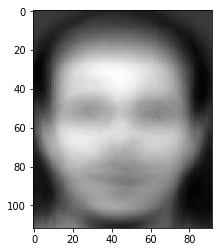

In [78]:
#show plot of average face
plt.imshow(average_face_output,cmap='gray')

In [29]:
#Computing the training set covariance matrix 
cov_train = train_set_centered.T.dot(train_set_centered)

In [31]:
#get the eigenvalues and eigenvectors of the covariance matrix 
eigenval, eigenvec = np.linalg.eig(cov_train)

In [62]:
#sorting the eigenvalues and eigenvectors of the covariance matrix
idx = np.argsort(eigenval)[::-1]
eigenval = eigenval[idx]
eigenvec = eigenvec[:,idx]

In [65]:
#Reconstruct correct eigenvectors
E = train_set_centered.dot(eigenvec)

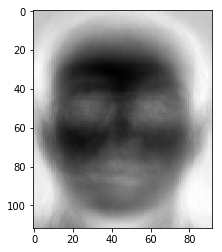

In [77]:
#Eigenface features of column 1
eigenface1 = np.reshape(E[:,0], (112,92)).astype(int)
plt.imshow(eigenface1, cmap='gray')

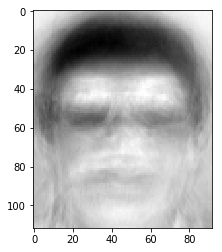

In [76]:
#Eigenface features of column 2
eigenface2 = np.reshape(E[:,1], (112,92)).astype(int)
plt.imshow(eigenface2, cmap='gray')

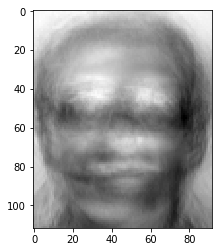

In [79]:
#Eigenface features of column 3
eigenface3 = np.reshape(E[:,2], (112,92)).astype(int)
plt.imshow(eigenface3, cmap='gray')

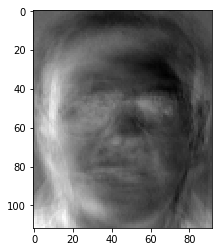

In [80]:
#Eigenface features of column 4
eigenface4 = np.reshape(E[:,3], (112,92)).astype(int)
plt.imshow(eigenface4, cmap='gray')

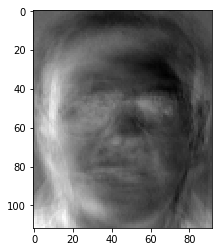

In [81]:
#Eigenface features of column 5
eigenface5 = np.reshape(E[:,4], (112,92)).astype(int)
plt.imshow(eigenface4, cmap='gray')

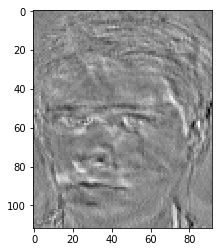

In [84]:
#Eigenface features of column -1
eigenface6 = np.reshape(E[:,-1], (112,92)).astype(int)
plt.imshow(eigenface6, cmap='gray')

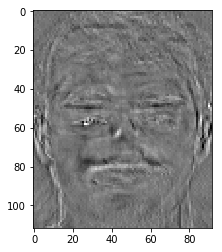

In [85]:
#Eigenface features of column -2
eigenface7 = np.reshape(E[:,-2], (112,92)).astype(int)
plt.imshow(eigenface7, cmap='gray')

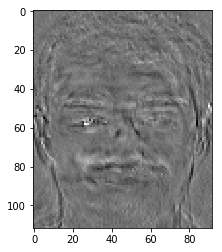

In [86]:
#Eigenface features of column -3
eigenface8 = np.reshape(E[:,-3], (112,92)).astype(int)
plt.imshow(eigenface8, cmap='gray')

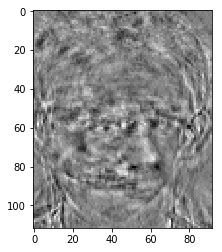

In [87]:
#Eigenface features of column -4
eigenface9 = np.reshape(E[:,-4], (112,92)).astype(int)
plt.imshow(eigenface9, cmap='gray')

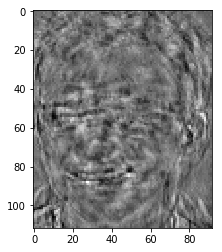

In [88]:
#Eigenface features of column -5
eigenface10 = np.reshape(E[:,-5], (112,92)).astype(int)
plt.imshow(eigenface10, cmap='gray')

In [89]:
#preparing the data for comparison 
#create a basis set out of the first 50 cols of eigenvec
basis = eigenvec[:,0:50]

In [102]:
proj_img = 0
for j in basis.astype(int):
    proj_img += basis.T[j].dot(test_set_centered) * basis[j]

ValueError: shapes (50,160) and (10304,80) not aligned: 160 (dim 1) != 10304 (dim 0)